In [2]:
import pandas as pd
from matplotlib import pyplot as plt

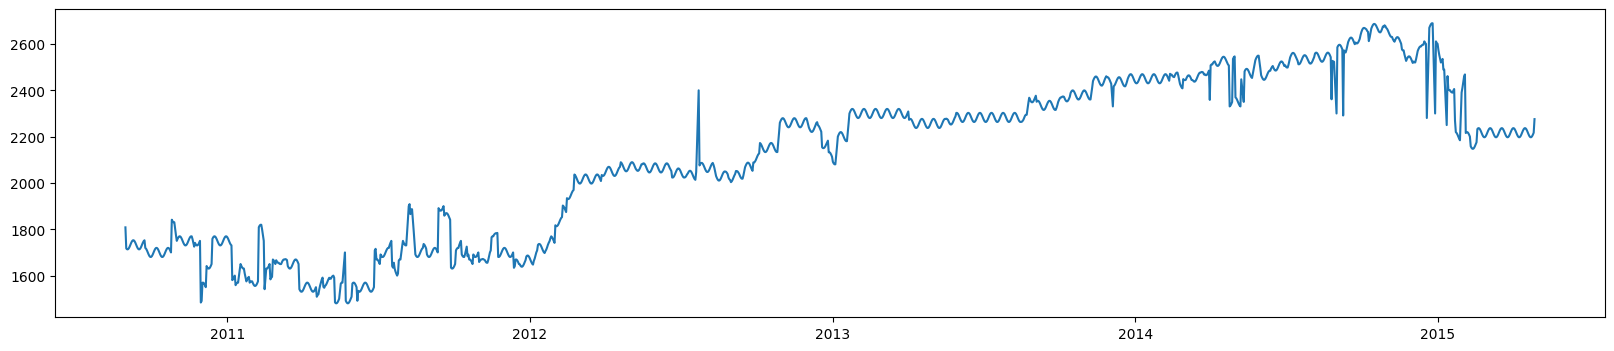

In [3]:
df = pd.read_csv("./data/market/Rice.Nagpur.csv")
df["Date"] = pd.to_datetime(df["Date"])
plt.figure(figsize=(20, 4))
plt.plot(df["Date"], df["Price"])

2023-12-18 15:40:19.379366: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 15:40:19.581244: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 15:40:19.581450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 15:40:19.629452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 15:40:19.717689: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 15:40:19.719060: I tensorflow/core/platform/cpu_feature_guard.cc:1

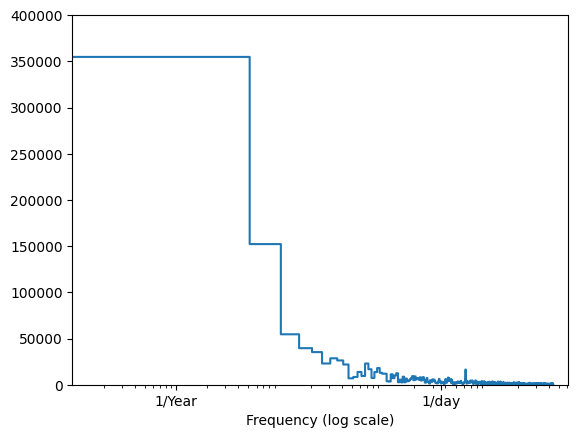

In [4]:
import tensorflow as tf
import numpy as np

fft = tf.signal.rfft(df["Price"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df["Price"])
hours_per_year = 24 * 365.2524
years_per_dataset = n_samples_h / (hours_per_year)

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale("log")
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=["1/Year", "1/day"])
_ = plt.xlabel("Frequency (log scale)")

In [5]:
df["Timestamp"] = np.arange(len(df))
date = df["Date"]
df = df.drop(columns=["Date"])

In [6]:
sequence_length = 7

sequences = []
for i in range(len(df) - sequence_length):
    seq = df.iloc[i : i + sequence_length]
    sequences.append(seq.values)

In [7]:
sequences = np.array(sequences).astype("float32")

In [8]:
X = sequences[:, :, :-1]
y = sequences[:, -1, -1]

TRAIN_LEN = int(0.7 * len(X))
TEST_LEN = int(0.1 * len(X))
VAL_LEN = len(X) - TRAIN_LEN - TEST_LEN

X_train = X[:TRAIN_LEN]
X_test = X[TRAIN_LEN : TRAIN_LEN + TEST_LEN]
X_val = X[-VAL_LEN:]


y_train = y[:TRAIN_LEN]
y_test = y[TRAIN_LEN : TRAIN_LEN + TEST_LEN]
y_val = y[-VAL_LEN:]

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential(
    [
        LSTM(units=50, activation="relu", input_shape=(sequence_length, X.shape[2])),
        Dense(1),
    ]
)

model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
model.fit(X_train, y_train, batch_size=14, epochs=50, validation_data=(X_val, y_val))

In [1]:
from joblib import dump, load

model = load("./out/forecast.Nagpur.Rice.joblib")

2023-12-18 16:51:44.924143: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 16:51:44.977698: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 16:51:44.977742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 16:51:44.979229: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 16:51:44.986992: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 16:51:44.988321: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [ ]:
predicted_value = model.predict(X_test)

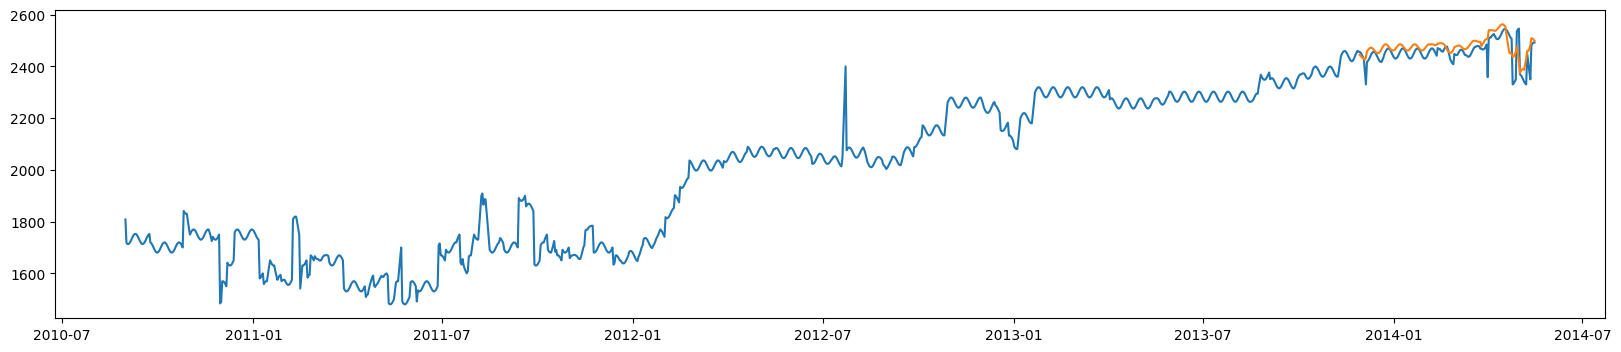

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(date[: TRAIN_LEN + TEST_LEN], df["Price"][: TRAIN_LEN + TEST_LEN])
plt.plot(date[TRAIN_LEN : TRAIN_LEN + TEST_LEN], predicted_value.flatten() * 3.1415)

In [11]:
dump(model, "./out/forecast.Nagpur.Rice.joblib")

TODO: Let's see next what data looks like after the week.